# Homework 4 (100 Points)

Collaborators : Ajit balla (U40978471) , Srinivas Chellaboina (U93606015)



## Exercise 1 (40pts)

In this exercise we will implement a Natural Language Processing (NLP) system using binary logistic regression.

The data you will be working with comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings. Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

### Part 1 (20pts)

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset. (10pts)

In [ ]:
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

################################################################################
# We have provided you the functions for loading the tsv and txt files. Feel   #
# free to use them! No need to change them at all.                             #
################################################################################


def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset):

    dataset = load_tsv_dataset(path_to_dataset)
    word2vec_map = load_feature_dictionary("word2vec.txt")
    
    # Initialize a new ndarray to store the trimmed reviews and labels
    trimmed_dataset = np.empty_like(dataset)
    
    # Iterate through the dataset and keep only the words that are present in the word2vec dictionary
    for idx, (label, review) in enumerate(dataset):
        words = review.split()
        trimmed_words = [word for word in words if word in word2vec_map]
        trimmed_review = " ".join(trimmed_words)
        
        # Store the trimmed review and label in the new ndarray
        trimmed_dataset[idx] = (label, trimmed_review)
    
    return trimmed_dataset

trim_train = trim_reviews("train_small.tsv")
trim_test = trim_reviews("test_small.tsv")


b) Implement the embedding and store it to a `.tsv` file where the first column is the label and the rest are the features from the embedding. Round all numbers to 6 decimal places. `embedded_train_small.tsv` and `embedded_test_small.tsv` contain the expected output of your function. (10pts)

In [ ]:
def embed_reviews(trimmed_dataset):
    # Load the word2vec embeddings
    word2vec_map = load_feature_dictionary("word2vec.txt")
    
    # Initialize an empty list to store the embedded reviews
    embedded_reviews = []
    
    # Iterate through the trimmed_dataset
    for label, review in trimmed_dataset:
        words = review.split()
        embeddings = [word2vec_map[word] for word in words]
        
        # Calculate the average of the word embeddings to get the review embedding
        review_embedding = np.mean(embeddings, axis=0)
        
        # Concatenate the label and the review embedding
        embedded_review = np.concatenate(([label], review_embedding))
        
        # Append the embedded_review to the list
        embedded_reviews.append(embedded_review)
    
    # Convert the list to an ndarray
    embedded_reviews_array = np.array(embedded_reviews, dtype=np.float32)
    
    return embedded_reviews_array


def save_as_tsv(dataset, filename):
    with open(filename, 'w+') as f:
        for row in dataset:
            # Round the numbers to 6 decimal places and convert them to strings
            rounded_row = [f"{value:.6f}" for value in row]
            line = "\t".join(rounded_row) + "\n"
            f.write(line)
    return


embedded_train = embed_reviews(trim_train)
embedded_test = embed_reviews(trim_test)

save_as_tsv(embedded_train, "/content/output/embedded_train_small.tsv")
save_as_tsv(embedded_test, "/content/output/embedded_test_small.tsv")

### Part 2 (20pts)

In this part we'll be implementing Gradient Descent for binary Logistic Regression Classifier.

Some rules:

1. Include an intercept term in your model. You must consider the bias term as part of the weight vector and not a separate term to keep track of.
2. Initialize all model parameters to 0
3. Use vector and matrix multiplication

The expected `metrics.txt` from the dataset with `500` epochs and `0.01` learning rate is:

```
error(train): 0.000000
error(test): 0.625000
```

We will be testing your code on other, larger datasets.

In [ ]:
import numpy as np

def load_tsv_dataset(file):
    return np.loadtxt(file, delimiter='\t', encoding='utf-8')


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def gd(theta, X, y, learning_rate):
    m = X.shape[0]
    y_pred = sigmoid(np.dot(X, theta))
    gradient = (1 / m) * np.dot(X.T, (y_pred - y))
    theta -= learning_rate * gradient
    return theta


def train(theta, X, y, num_epoch, learning_rate):
    for _ in range(num_epoch):
        theta = gd(theta, X, y, learning_rate)
    return theta


def predict(theta, X):
    probabilities = sigmoid(np.dot(X, theta))
    return (probabilities >= 0.5).astype(int)


def compute_error(y_pred, y):
    return np.mean(y_pred != y)



def write_metrics(train_err, test_err, metrics_out):
    with open(metrics_out, 'w+') as f:
        w = "error(train): " + "{:.6f}".format(train_err) + "\n"
        w += "error(test): " + "{:.6f}".format(test_err) + "\n"
        f.write(w)
    return


def logistic_reg(formatted_train, formatted_test, metrics_out, num_epochs, learning_rate):
    train_data = load_tsv_dataset(formatted_train)
    test_data = load_tsv_dataset(formatted_test)
    
    y = train_data[:, 0]
    X = np.column_stack((np.ones(train_data.shape[0]), train_data[:, 1:]))
    theta = np.zeros(X.shape[1])

    learned_theta = train(theta, X, y, num_epochs, learning_rate)
    train_pred = predict(learned_theta, X)
    train_err = compute_error(train_pred, y)

    y_test = test_data[:, 0]
    X_test = np.column_stack((np.ones(test_data.shape[0]), test_data[:, 1:]))
    test_pred = predict(learned_theta, X_test)
    test_err = compute_error(test_pred, y_test)

    write_metrics(train_err, test_err, metrics_out)
    return

logistic_reg("/content/output/embedded_train_small.tsv", "/content/output/embedded_test_small.tsv", "/content/output/metrics.txt", 500, 0.01)


## Exercise 2 (60 Points)

For this exercise, recall the lab's kaggle competition where you predicted if a cookie was defective or not (assuming you attend labs). For more information on the data and details, [click here to view the competition and data details](https://www.kaggle.com/competitions/cs506-lab-defective-cookie-detection/data)

However, what we will do differently here is check if two of the features were correlated. This is important because if two features are correlated, then we can remove one of the features and still get the same information. This is part of the feature selection process.

### Loading in the Data

For this exercise, we are interested in the two features `Texture Hardness` and `Texture Chewiness` and want to see if they are related. To do this, we will load in the data and create a scatter plot of the two features.

**a)** (1 Point) Download the kaggle data from the link above and read in the `csv` files `cookie_train.csv` and `cookie_test.csv`

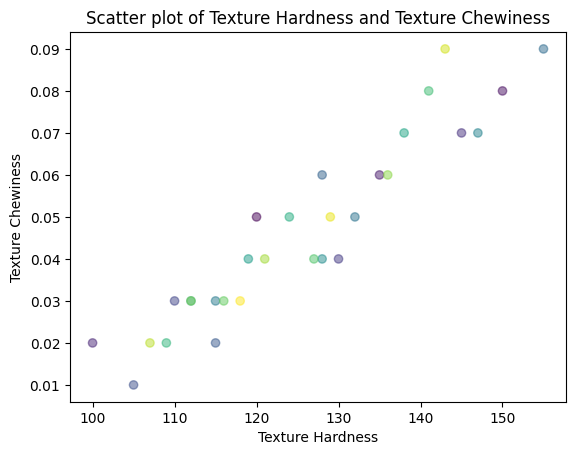

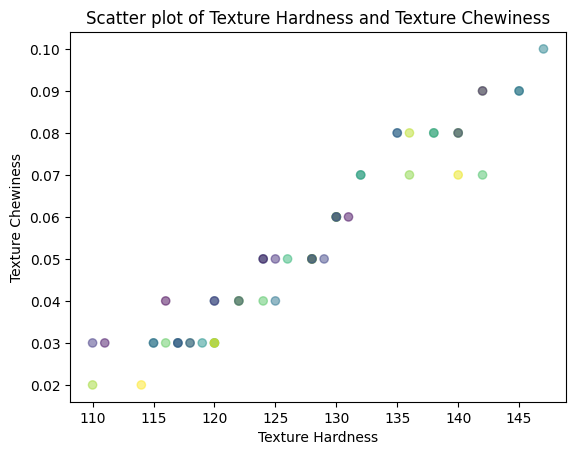

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

plt.scatter(train_data['Texture Hardness'], train_data['Texture Chewiness'], c=train_data['Id'], cmap='viridis', alpha=0.5)
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Scatter plot of Texture Hardness and Texture Chewiness')

plt.show()

plt.scatter(test_data['Texture Hardness'], test_data['Texture Chewiness'], c=test_data['Id'], cmap='viridis', alpha=0.5)
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Scatter plot of Texture Hardness and Texture Chewiness')

plt.show()


### Combining Training and Testing Data

The lab did not have a lot of cookies for the training set, so what we will do is combine the training and testing data together without any loss of generality.

**b)** (3 Point) Combine the training and testing data together into a single dataframe called `cookie_data` and plot the scatter plot for `Texture Chewiness` (our y or our response variable) and `Texture Hardness` (our x or our explanatory variable). Make sure to label your axes and give your plot a title.

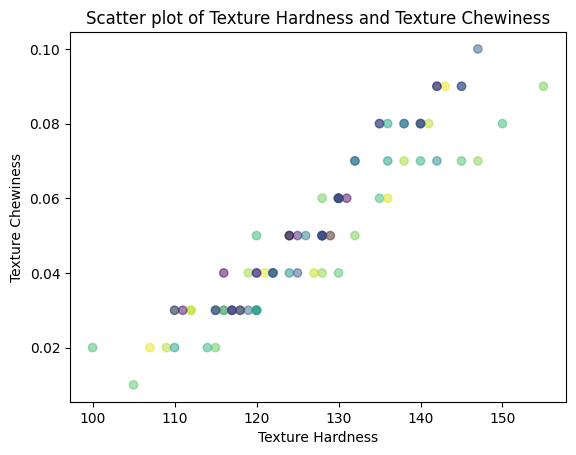

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data])

plt.scatter(cookie_data['Texture Hardness'], cookie_data['Texture Chewiness'], c=cookie_data['Id'], cmap='viridis', alpha=0.5)
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Scatter plot of Texture Hardness and Texture Chewiness')

plt.show()


### Checking If We Can Do Linear Regression

It is important to check all requirements/assumptions for linear regression are met before we do linear regression. One of the requirements is that the explanatory variable and response variable are linearly related, which we checked by noticing the scatter plot was linear. However, there is much more to check!

#### Checking for Normality
It is important to check that the response variable is normally distributed. This is important for hypothesis testing and relates to the idea of linear regression being an unbiased, minimum variance estimator (if you're interested in this, check out the course CAS MA 582).


**c) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the normality assumption. State whether the normality assumption is met or not. If it is not met, state what can we do to fix this.

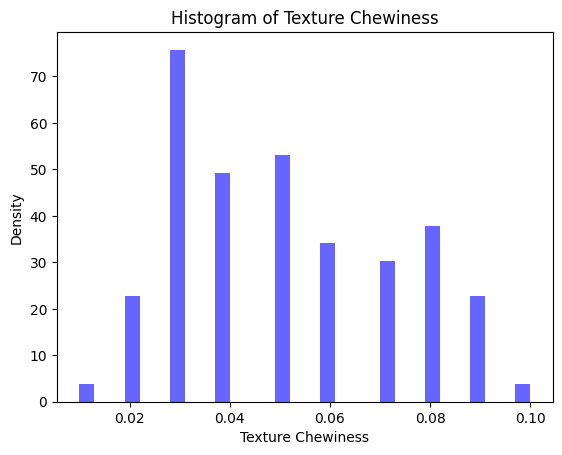

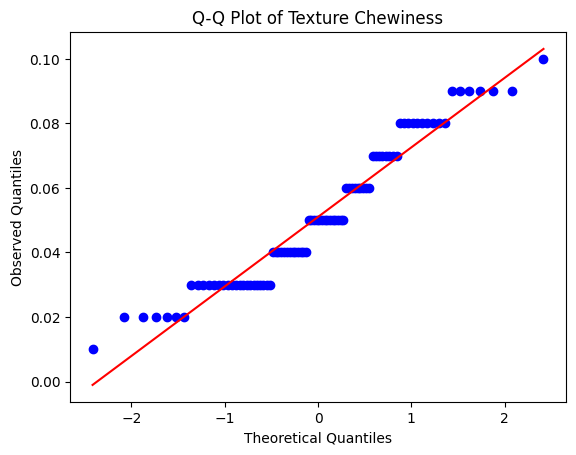

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data])

plt.hist(cookie_data['Texture Chewiness'], bins=30, density=True, alpha=0.6, color='b')
plt.xlabel('Texture Chewiness')
plt.ylabel('Density')
plt.title('Histogram of Texture Chewiness')
plt.show()

stats.probplot(cookie_data['Texture Chewiness'], dist="norm", plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Quantiles')
plt.title('Q-Q Plot of Texture Chewiness')
plt.show()


its not quite a bell shapped histogram so we can conlude that it has not met but then to make it better we can use some transformation functions like log and try it out

#### Checking for Homoscedasticity
It is important to check that the variance of the response variable is the same across all values of the explanatory variable. Otherwise, the confidence around a predicted value of the response variable will vary depending on the explanatory variable value.

**d) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the homoscedasticity assumption. State whether the homoscedasticity assumption is met or not. If it is not met, state what can we do to fix this.

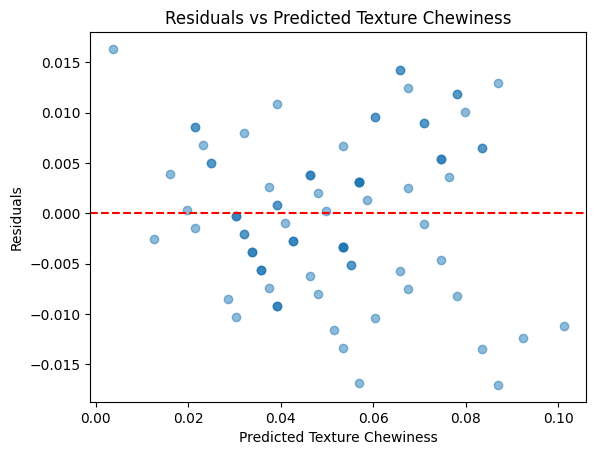

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data])

X = cookie_data[['Texture Hardness']].values
y = cookie_data['Texture Chewiness'].values

model = LinearRegression()
model.fit(X, y)

predicted_y = model.predict(X)
residuals = y - predicted_y

plt.scatter(predicted_y, residuals, alpha=0.5)
plt.xlabel('Predicted Texture Chewiness')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Texture Chewiness')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


the points are randomly and evenly spread so homoscedasticity is met in this case

#### Checking for Independence
It is important to check that the explanatory variable and response variable are independent. Otherwise, the model isn't really best fit with a line. To do so, we will use the Durbin-Watson test.

**e) (5 Points)** Use the Durbin-Watson test to determine if the explanatory variable and response variable are independent. State whether if the independence assumption is met or not. If it is not met, state what can we do to fix this. You may use any library to do this, and for more information, check out [this link](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson

train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data])

X = cookie_data[['Texture Hardness']].values
y = cookie_data['Texture Chewiness'].values

model = LinearRegression()
model.fit(X, y)

predicted_y = model.predict(X)
residuals = y - predicted_y

dw_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw_stat)


Durbin-Watson statistic: 2.2797136857816565


in this case explanatory variable and response variable are independent. beacasue our score is arround 2.2 which is decent enough to prove

#### Adjusting the Model
If you think any of the assumptions are not met, then you should respectively fix the model.

**f) (6 Points)** If you think atleast one of the assumptions were not met, then adjust the model how you described you would. Otherwise, proceed to the next step and in the cell below, write "No adjustments were made to the model". However, if you do adjust the model, then in the cell below, justify why your adjustments is appropriate (i.e. plot the new graphs and statistics found above). You may add as many cells as you like.

In [ ]:
 # "No adjustments were made to the model"

### Hypothesis Testing
Now that we have a model that is appropriate, we can do hypothesis testing. We will be using the Linear Regression t-test to test if the explanatory variable is a significant predictor of the response variable.

**g) (5 Points)** Use the Linear Regression t-test to determine if the explanatory variable `Texture Hardness` is a significant predictor of the response variable `Texture Chewiness`. State whether if the explanatory variable is a significant predictor of the response variable or not using an alpha significance level of $\alpha = 0.05$, the null hypothesis $\beta_{hardness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

In [ ]:
import pandas as pd
import statsmodels.api as sm


train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data])

X = cookie_data[['Texture Hardness']]
X = sm.add_constant(X)  
y = cookie_data['Texture Chewiness']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     625.0
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           3.27e-41
Time:                        03:03:41   Log-Likelihood:                 305.19
No. Observations:                  88   AIC:                            -606.4
Df Residuals:                      86   BIC:                            -601.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1736      0.009  

given the above case null hypothesis  𝛽ℎ𝑎𝑟𝑑𝑛𝑒𝑠𝑠=0 can be rejected and the explanatory variable is a significant predictor of the response variable. which means that Texture Hardness is a significant predictor of the response variable Texture Chewiness



### Adding a New Feature
Now that we have determined that the explanatory variable is a significant predictor of the response variable, you noticed the fit isn't 100% perfect still (e.g. your model is not capturing all the variation in the data). You think that there is another feature that can help improve the model. You think that the feature `Taste Sweetness` can help improve your model. You want to test if this is true. You may assume that all the assumptions are met for this new model to conduct linear regression.

**h) (10 Points)** Now that you have two features to predict your response variable, you will have to use multiple linear regression. Use the `statsmodels` library to do multiple linear regression. Then, determine if the explanatory variables `Texture Hardness` and `Taste Sweetness` are significant predictors of the response variable `Texture Chewiness` using an alpha significance level of $\alpha = 0.001$, the null hypothesis $\beta_{hardness} = 0$ and $\beta_{sweetness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$ and $\beta_{sweetness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

Moreover, justify whether the overall model is significant or not using the F-test with the same $\alpha$ given above. If it is not, state what can we do to fix this.

_You may use the transformed model made (if one was made) from the previous parts and add this new feature to it._

In [ ]:
import pandas as pd
import statsmodels.api as sm

train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data])

X = cookie_data[['Texture Hardness', 'Taste Sweetness']]
X = sm.add_constant(X)  
y = cookie_data['Texture Chewiness']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     560.2
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           1.13e-49
Time:                        03:03:41   Log-Likelihood:                 328.93
No. Observations:                  88   AIC:                            -651.9
Df Residuals:                      85   BIC:                            -644.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1096      0.011  

in this case too we reject the null hypothesis and conclude that  explanatory variables Texture Hardness and Taste Sweetness are significant predictors of the response variable Texture Chewiness

### Interpretation
It is important to be able to interpret the results of the model. This is important because it allows us to understand the model and how it works. It also allows us to understand the relationship between the predictors and the response variable, and this applies to not just linear regression, but all learning models.

**i) (10 Points)** Interpret the coefficients of the model made in part **h**. What do they mean? What do they represent? What do they tell us about the relationship between the predictors and the response variable? If your code output in part h does not provide these results, you are welcome to use any library here to do so.

In [ ]:
#Your code in this cell if you need it

The model is good fit for the data.
Constant : The constant in this instance is -0.1096, which means that when both Taste Sweetness and Texture Hardness are zero, the anticipated Texture Chewiness should be -0.1096.
Texture Hardness: The coefficient for Texture Hardness is 0.0011, which implies that, while all other factors are held constant, it is predicted that the Texture Chewiness would rise by 0.0011 units for every unit increase in Texture Hardness.
Taste Sweetness: The coefficient for Taste Sweetness is 0.0107, which implies that, when all other factors are held constant, it is estimated that the Texture Chewiness would rise by 0.0107 units for every unit increase in Taste Sweetness. 
The correlation between texture hardness and texture chewiness is positive, as seen by the positive coefficient.The positive coefficient shows a positive link between Taste Sweetness and Texture Chewiness. 
According to the R-squared value of 0.929, the model accounts for around 92.9% of the variation in texture chewiness. 
as discussed above,P-values less than 0.001 (significance threshold) indicate that Texture Hardness and Taste Sweetness are significant predictors of Texture Chewiness.

### Using Taste Bitterness over Taste Sweetness
You think that the feature `Taste Bitterness` can help improve your model since `Taste Sweetness` wasn't it.

For this section, you will continue to use your fixed/adjusted features for `Texture Hardness` and `Texture Chewiness`.

**j) (10 Points)** Plot 2 scatter plots: `Taste Bitterness` vs your possibly adjusted `Texture Chewiness` and `Taste Bitterness` vs your possibly adjusted `Texture Hardness`. Given these plots, propose an appropriate model. Justify your answer by fitting it and seeing its accuracy (you can use any metric to prove so), showing appropriate models/graphs, and ensuring assumptions are satisfied (if any). You may use any library to do this.

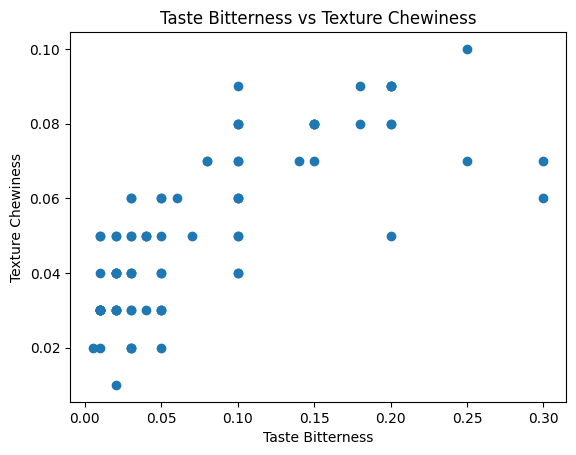

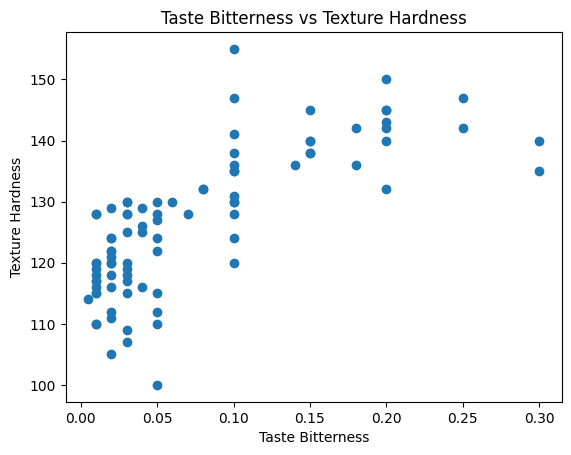

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     369.7
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           2.84e-48
Time:                        03:03:43   Log-Likelihood:                 329.00
No. Observations:                  88   AIC:                            -650.0
Df Residuals:                      84   BIC:                            -640.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1109      0.011  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cookie_data['Taste Bitterness'] = cookie_data['Taste Bitterness']

plt.scatter(cookie_data['Taste Bitterness'], cookie_data['Texture Chewiness'])
plt.xlabel('Taste Bitterness')
plt.ylabel('Texture Chewiness')
plt.title('Taste Bitterness vs Texture Chewiness')
plt.show()

plt.scatter(cookie_data['Taste Bitterness'], cookie_data['Texture Hardness'])
plt.xlabel('Taste Bitterness')
plt.ylabel('Texture Hardness')
plt.title('Taste Bitterness vs Texture Hardness')
plt.show()

import statsmodels.api as sm

X = cookie_data[['Texture Hardness', 'Taste Sweetness', 'Taste Bitterness']]
y = cookie_data['Texture Chewiness']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


The OLS regression findings show that the R-squared value has marginally improved from 0.929 to 0.930, indicating a modest improvement in the model's capacity to explain the variance in Texture Chewiness. The p-value for Taste Bitterness, however, is 0.717, which is not significant at the selected alpha level of 0.001. This implies that Taste Bitterness is not a major predictor of Texture Chewiness, and so its inclusion in the model might not enhance its performance. the proposed linear regression model can be: Texture Chewiness = β0 + β1 * Texture Hardness + β2 * Taste Sweetness .Texture Chewiness is predicted by this model, which has a respectable R-squared value of 0.929, using Texture Hardness and Taste Sweetness.

## Bonus (20pts)

Lasso Regression is a modification of Regression that adds a regularization penalty to the the parameter $\mathbf{\beta}$ learned by the model. The loss function for Lasso is the following:

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2 + \lambda \Vert \mathbf{\beta} \Vert = \beta^T X^T X \beta - 2\mathbf{\beta}^TX^T\mathbf{y}  + \mathbf{y}^T\mathbf{y} + \lambda \Vert \mathbf{\beta} \Vert$$

Where $\lambda$ is a tuning parameter specified by the user.

Using worksheet 17 as a guide:

1. create an animation like in part c) for Lasso Regression. [15pts]
2. create at least two more animations using different values for $\lambda$ and the true $\mathbf{\beta}$ you used to generate the dataset (try steeper / less steep curves, and higher or close to zero intercepts). Briefly explain some key takeaways on how to tune $\lambda$. [5pts]

<ipython-input-14-54a688eafa19>:49: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_ydata(coefficients[num, i])


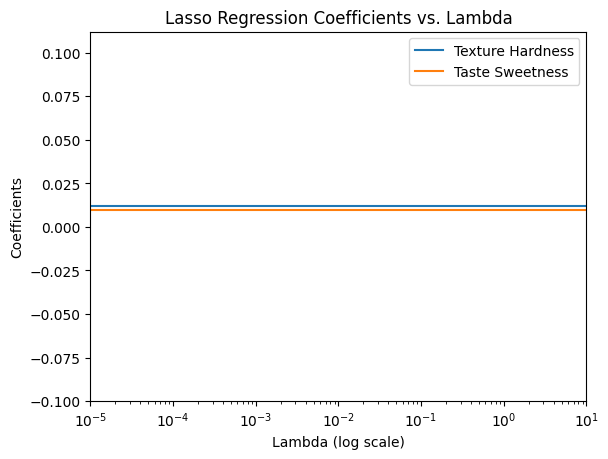

<ipython-input-14-54a688eafa19>:49: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_ydata(coefficients[num, i])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

cookie_data = pd.concat([train_data, test_data], axis=0)

X = cookie_data[['Texture Hardness', 'Taste Sweetness']]
y = cookie_data['Texture Chewiness']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lambdas = np.logspace(-5, 1, 50)

coefficients = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

fig, ax = plt.subplots()
lines = [ax.plot(lambdas, coefficients[:, i], label=X.columns[i])[0] for i in range(X.shape[1])]
ax.set_xscale("log")
ax.set_xlim(lambdas.min(), lambdas.max())
ax.set_ylim(coefficients.min() - 0.1, coefficients.max() + 0.1)
ax.set_xlabel("Lambda (log scale)")
ax.set_ylabel("Coefficients")
ax.set_title("Lasso Regression Coefficients vs. Lambda")
ax.legend()

def update(num, lambdas, coefficients, lines):
    for i, line in enumerate(lines):
        line.set_ydata(coefficients[num, i])
    return lines

ani = animation.FuncAnimation(fig, update, frames=len(lambdas), fargs=(lambdas, coefficients, lines), interval=100, blit=True)
plt.show()
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
HTML(ani.to_jshtml())

<ipython-input-22-f4dd19b75c0f>:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_ydata(coefficients[num, i])
<ipython-input-22-f4dd19b75c0f>:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_ydata(coefficients[num, i])
<ipython-input-22-f4dd19b75c0f>:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_ydata(coefficients[num, i])


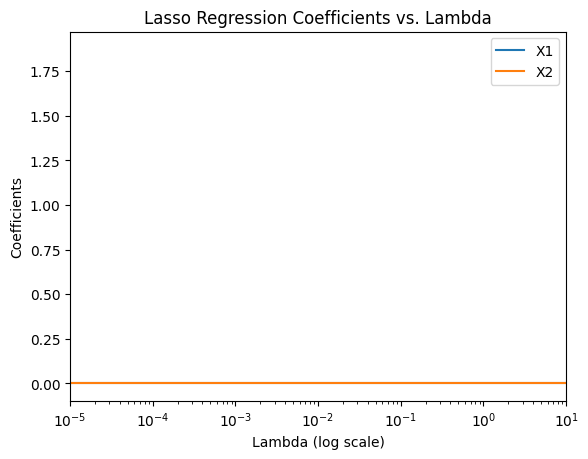

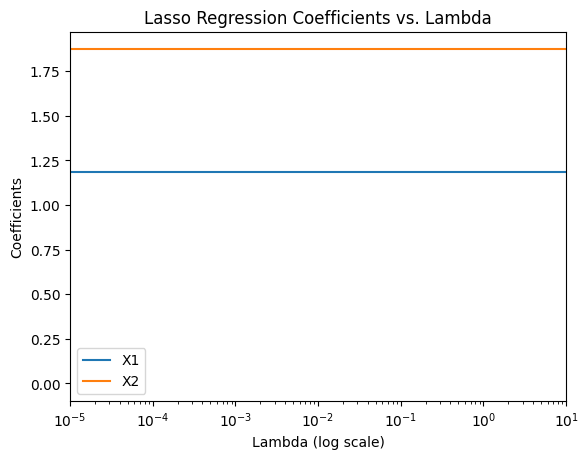

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.linear_model import Lasso

def lasso_regression(X, y, alpha):
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    return lasso.coef_

def create_animation(X, y, alpha):
    fig, ax = plt.subplots()

    lambdas = np.logspace(-5, 1, 50)
    coefficients = []

    for lam in lambdas:
        coef = lasso_regression(X, y, alpha=lam)
        coefficients.append(coef)

    coefficients = np.array(coefficients)

    lines = [ax.plot(lambdas, coefficients[:, i], label=X.columns[i])[0] for i in range(X.shape[1])]
    ax.set_xscale("log")
    ax.set_xlim(lambdas.min(), lambdas.max())
    ax.set_ylim(coefficients.min() - 0.1, coefficients.max() + 0.1)
    ax.set_xlabel("Lambda (log scale)")
    ax.set_ylabel("Coefficients")
    ax.set_title("Lasso Regression Coefficients vs. Lambda")
    ax.legend()

    def update(num, lambdas, coefficients, lines):
        for i, line in enumerate(lines):
            line.set_ydata(coefficients[num, i])
        return lines

    return FuncAnimation(fig, update, frames=len(lambdas), fargs=(lambdas, coefficients, lines), interval=100, blit=True)


np.random.seed(123)
X = np.random.randn(100, 3)
beta = np.array([1, 2, 0])
y = X.dot(beta) + np.random.normal(0, 1, size=100)

animation1 = create_animation(pd.DataFrame(X[:, :2], columns=['X1', 'X2']), y, 1)
animation2 = create_animation(pd.DataFrame(X[:, :2], columns=['X1', 'X2']), y, 0.1)

HTML(animation1.to_jshtml())


In [ ]:
HTML(animation2.to_jshtml())